<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/7_Deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning for image classification

We demonstrate deep learning on image classification in the CIFAR-10 dataset. The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The notebook foucses is on reusing own or third party training results.

Import the necessary libraries.

In [2]:
import os
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from keras.models import Model, Sequential
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications import VGG19, ResNet50

import numpy as np
import matplotlib.pyplot as plt

Load the CIFAR-10 dataset.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


Prepare the dataset.

In [5]:
# Normalize
x_train, x_test = x_train / 255.0, x_test / 255.0
print(np.amin(x_train),np.amax(x_train))

# flatten the label values
y_train, y_test = y_train.flatten(), y_test.flatten()

0.0 1.0


Visualize data by plotting images.

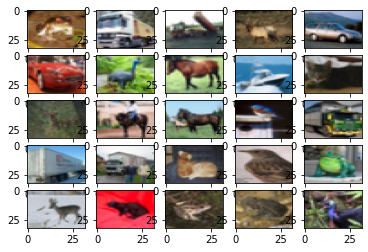

In [4]:
fig, ax = plt.subplots(5, 5)
k = 0
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
 
plt.show()

We define a function that creates the model. Note that [Batch normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [5]:
def create_model():
  # number of classes
  K = len(set(y_train))

  # calculate total number of classes for output layer
  print("number of classes:", K)

  # Build the model using the functional API
  # input layer
  i = Input(shape=x_train[0].shape)

  # Hidden layers
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.2)(x)

  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)

  # Output layer
  x = Dense(K, activation='softmax')(x)

  model = Model(i, x)

  # Compile
  model.compile(optimizer='adam',
			loss='sparse_categorical_crossentropy',
			metrics=['accuracy'])
  
  model.summary()
  
  return model

In [ ]:
model = create_model()

number of classes: 10
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 

To train the initial model takes ca 100 minutes, so start before lunch.

In [57]:
train_initial_model = False

In [ ]:
if train_initial_model:
  r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1563/1563 [==============================] - 580s 370ms/step - loss: 1.2967 - accuracy: 0.5547 - val_loss: 1.1692 - val_accuracy: 0.6135
Epoch 2/10
1563/1563 [==============================] - 549s 351ms/step - loss: 0.8355 - accuracy: 0.7095 - val_loss: 0.8727 - val_accuracy: 0.7000
Epoch 3/10
1563/1563 [==============================] - 607s 388ms/step - loss: 0.6879 - accuracy: 0.7619 - val_loss: 0.8167 - val_accuracy: 0.7209
Epoch 4/10
1563/1563 [==============================] - 613s 392ms/step - loss: 0.5849 - accuracy: 0.8008 - val_loss: 0.6734 - val_accuracy: 0.7758
Epoch 5/10
1563/1563 [==============================] - 576s 369ms/step - loss: 0.4973 - accuracy: 0.8278 - val_loss: 0.6101 - val_accuracy: 0.7956
Epoch 6/10
1563/1563 [==============================] - 578s 370ms/step - loss: 0.4203 - accuracy: 0.8531 - val_loss: 0.7256 - val_accuracy: 0.7825
Epoch 7/10
1563/1563 [==============================] - 547s 350ms/step - loss: 0.3570 - accuracy: 0.8761 - val_

If we train, we see that there are $1563$ gradient descent iterations in each epoch. For each iteration, $50000/1563\approx 32$ images are used. This is controlled by the batch size, which is $32$ by default. We make that explicit outside the Tensorflow library.

In [6]:
batch_size = 32

We can show the training history. However, if we did not train, there is no result $\verb|r|$. 

In [7]:
def show_training_history(r):
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()

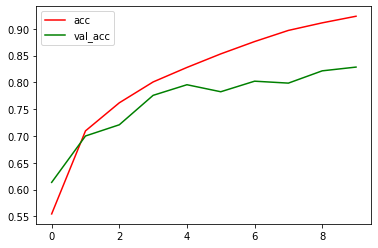

In [ ]:
if train_initial_model:
  show_training_history(r)

Save models and intermediate results as expleined in [this](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb) notebook. However, to have it saved persistently over colab sessions, we need to mount our Google drive and crate a directory there.

In [9]:
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/Colab Notebooks/Models'
if train_initial_model:
  if not os.path.isdir(path):
    os.mkdir(path)
  # Saves the entire model (weights and architecture)
  model.save(path+'/my_model')
  os.listdir(path)

Mounted at /content/gdrive


To test persistency, we load the model from drive, check its architecture, and evaluate the restored model.


In [10]:
new_model = tf.keras.models.load_model(path+'/my_model')
new_model.summary()
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
print(new_model.predict(x_test).shape)
#we continue to work with this new model
model = new_model

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0   

Use the model for classification.

In [11]:
def predict_label(model, x_test, y_test, image_number):
  # label mapping
  labels = "airplanes cars birds cats deer dogs frogs horses ships trucks".split() 
  # display the image
  fig, ax = plt.subplots(figsize=(2,2))
  ax.imshow(x_test[image_number], interpolation='nearest')
  plt.tight_layout()
  # load the image in an array
  n = np.array(x_test[image_number])
  # reshape it
  p = n.reshape(1, 32, 32, 3)
  # pass in the network for prediction and
  # save the predicted label
  predicted_label = labels[model.predict(p).argmax()]
  # load the original label
  original_label = labels[y_test[image_number]]
  # display the result
  print("Original label is {} and predicted label is {}".format(original_label, predicted_label))

1/1 [==============================] - 0s 32ms/step
Original label is airplanes and predicted label is airplanes


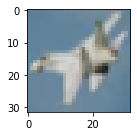

In [12]:
predict_label(model, x_test, y_test, 10) #0-9 correct

For interrupting and resuming the training, we can save intermediate weights at checkpoints. Therefore, we create a callback function that is regularily called during training, like the early stopping callback from Notebook [6_Neural_Networks](https://github.com/WelfLowe/ML4developers/blob/main/6_Neural_Networks.ipynb).

In [13]:
checkpoint_path = path+'/my_model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Also, we want to improve the model by using data augmentation, i.e., modifying the images randomly and so create more images for training.

In [7]:
data_generator = ImageDataGenerator(rotation_range=10, fill_mode='nearest', horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [15]:
continue_training = False

Epoch 1/10
1562/1562 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.8324
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/Models/my_model/cp.ckpt
1562/1562 [==============================] - 590s 377ms/step - loss: 0.5153 - accuracy: 0.8324 - val_loss: 0.6195 - val_accuracy: 0.8083
Epoch 2/10
1562/1562 [==============================] - ETA: 0s - loss: 0.4512 - accuracy: 0.8495
Epoch 2: saving model to /content/gdrive/MyDrive/Colab Notebooks/Models/my_model/cp.ckpt
1562/1562 [==============================] - 574s 367ms/step - loss: 0.4512 - accuracy: 0.8495 - val_loss: 0.5484 - val_accuracy: 0.8295
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 0.4084 - accuracy: 0.8633
Epoch 3: saving model to /content/gdrive/MyDrive/Colab Notebooks/Models/my_model/cp.ckpt
1562/1562 [==============================] - 569s 364ms/step - loss: 0.4084 - accuracy: 0.8633 - val_loss: 0.5428 - val_accuracy: 0.8303
Epoch 4/10
1562/1562 [======

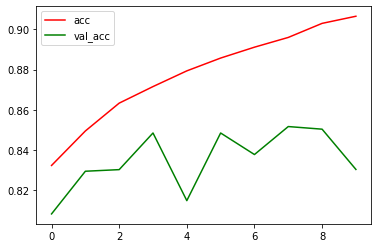

In [ ]:
if continue_training:
  r = model.fit(train_generator, 
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch, 
              callbacks=[cp_callback],
              epochs=10)
  show_training_history(r)

In [16]:
os.listdir(checkpoint_dir)

['variables',
 'assets',
 'keras_metadata.pb',
 'saved_model.pb',
 'cp.ckpt.index',
 'cp.ckpt.data-00000-of-00001',
 'cp.ckpt_1.index',
 'cp.ckpt_1.data-00000-of-00001',
 'cp.ckpt_2.index',
 'checkpoint',
 'cp.ckpt_2.data-00000-of-00001']

In [17]:
new_model = create_model()
new_model.summary()

number of classes: 10
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16

In [18]:
new_model.load_weights(checkpoint_path)
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 19s - loss: 0.5516 - accuracy: 0.8304 - 19s/epoch - 61ms/step
Restored model, accuracy: 83.04%


Finally, let's benefit from other models trained on similar problems using so called transfer learning.


Unrelated to that, we change to one-hot encoding, which often gives more accurate classification results.

In [8]:
y_train_1=to_categorical(y_train)
y_test_1=to_categorical(y_test)
data_generator_1 = ImageDataGenerator(rotation_range=10, fill_mode='nearest', horizontal_flip=True)
train_generator_1 = data_generator.flow(x_train, y_train_1)
y_test_1.shape

(10000, 10)

Load two pretrained image processing models.


In [9]:
base_model_1 = VGG19(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train_1.shape[1])
base_model_2 = ResNet50(include_top=False,weights='imagenet',input_shape=(32,32,3),classes=y_train_1.shape[1])

94765736/94765736 [==============================] - 1s 0us/step


Lets add the final layers to these base models where the actual classification is done in the dense layers. Mind that we mark the base model weights as not trainable. Also, mind the difference between that loss function for the one-hot encoded classification problem vs. the loss function for the original problem.

In [16]:
def create_transfer_model(base_model, one_hot=True, train_last = -1):
  if (train_last == -1):
    base_model.trainable = False
  else:
    number_of_layers = len(base_model.layers)
    number_of_training_layers = max(0,number_of_layers-train_last)
    for layer in base_model.layers[:number_of_training_layers]:
      layer.trainable = False

  model= Sequential()
  #Adds the base model (in this case vgg19/ResNet50 to model)
  model.add(base_model) 
  model.add(Flatten())
  #Add the Dense layers along with activation and batch normalization
  model.add(Dense(1024,activation=('relu'),input_dim=512))
  model.add(Dense(512,activation=('relu'))) 
  model.add(Dense(256,activation=('relu'))) 
  #Optionally, add a dropout layer that will randomly drop 30% of the weights
  model.add(Dropout(.2))
  model.add(Dense(128,activation=('relu')))
  model.add(Dropout(.2))
  #This is the classification layer
  model.add(Dense(10,activation=('softmax'))) 
  if one_hot:
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    print("ONE HOT")
  else:
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print("NOT ONE HOT")
    
  model.summary()
  return model

In [22]:
model_1 = create_transfer_model(base_model_1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [23]:
checkpoint_path_1 = path+'/my_model/cp.ckpt_1'
checkpoint_dir_1 = os.path.dirname(checkpoint_path_1)

# Create a callback that saves the model's weights
cp_callback_1 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_1,
                                                 save_weights_only=True,
                                                 verbose=1)

Still takes quite some time, even if we only train a fraction of the parameters. So stop and resume from the checkpoint if you loose patiance.

In [27]:
train_model_1 = False
if train_model_1:
  model_1.fit(train_generator_1,
            validation_data=(x_test, y_test_1),
            steps_per_epoch=steps_per_epoch, 
            callbacks=[cp_callback_1],
            epochs=10)
else:
  model_1.load_weights(checkpoint_path_1)
loss, acc = model_1.evaluate(x_test, y_test_1, verbose=2)
print('VGG19 based transfer model, accuracy: {:5.2f}%'.format(100 * acc))

313/313 - 138s - loss: 1.2056 - accuracy: 0.5911 - 138s/epoch - 440ms/step
VGG19 based transfer model, accuracy: 59.11%


Not too impressive.

Let's check the other base model, this time without one-hot encoding.

In [68]:
model_2 = create_transfer_model(base_model_2, one_hot=False)

NOT ONE HOT
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_52 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_53 (Dense)            (None, 512)               524800    
                                                                 
 dense_54 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_55 (Dense)            (None, 128) 

In [60]:
checkpoint_path_2 = path+'/my_model/cp.ckpt_2'
checkpoint_dir_2 = os.path.dirname(checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)

In [70]:
train_model_2 = True
if train_model_2:
  r = model_2.fit(train_generator,
            validation_data=(x_test, y_test),
            steps_per_epoch=steps_per_epoch, 
            callbacks=[cp_callback_2],
            epochs=10)
else:
  model_2.load_weights(checkpoint_path_2)
loss, acc = model_2.evaluate(x_test, y_test, verbose=2)
print('ResNet50 based transfer model, accuracy: {:5.2f}%'.format(100 * acc))

Epoch 1/10
1562/1562 [==============================] - ETA: 0s - loss: 1.7922 - accuracy: 0.3478
Epoch 1: saving model to /content/gdrive/MyDrive/Colab Notebooks/Models/my_model/cp.ckpt_2
1562/1562 [==============================] - 320s 205ms/step - loss: 1.7922 - accuracy: 0.3478 - val_loss: 1.7685 - val_accuracy: 0.3602
Epoch 2/10
1562/1562 [==============================] - ETA: 0s - loss: 1.7918 - accuracy: 0.3492
Epoch 2: saving model to /content/gdrive/MyDrive/Colab Notebooks/Models/my_model/cp.ckpt_2
1562/1562 [==============================] - 314s 201ms/step - loss: 1.7918 - accuracy: 0.3492 - val_loss: 1.7423 - val_accuracy: 0.3658
Epoch 3/10
1562/1562 [==============================] - ETA: 0s - loss: 1.7784 - accuracy: 0.3522
Epoch 3: saving model to /content/gdrive/MyDrive/Colab Notebooks/Models/my_model/cp.ckpt_2
1562/1562 [==============================] - 319s 205ms/step - loss: 1.7784 - accuracy: 0.3522 - val_loss: 1.7433 - val_accuracy: 0.3679
Epoch 4/10
1562/1562 [

In [ ]:
if train_model_2:
  show_training_history(r)

Not too impressive either. You may try to 

* Continue training the models.
* Select another base model; here the list of [available models](https://keras.io/api/applications/).
* Make the last layers of the basemodel trainable; see code below to make the last 3 layers of the baseline model trainable (mind the increase in the number of trainable parameters).
* Select another optimizer; here the list of [available algorithms](https://keras.io/api/optimizers/).
* Reduce learning rate, maybe dynamically in a callback.



In [17]:
model_3 = create_transfer_model(base_model_1, True, 3)

ONE HOT
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)        